In [1]:
# !pip install numpy pandas scipy scikit-learn matplotlib tqdm --quiet

import os, re, glob, math, warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu

# ---- paths & sets ----
BASE = r"E:\Collaboration Work\With Farooq\phm dataset\PHM Challange 2010 Milling"
TRAIN_CUTTERS = ["c1","c4","c6"]  # have labels (only to learn feature polarity/weights & for evaluation)
TEST_CUTTERS  = ["c2","c3","c5"]  # unlabeled

# ---- windowing ----
WIN = 4096
HOP = 2048
MAX_WINDOWS = 96  # max windows per cut (pad/truncate)

# ---- HI & DMW params ----
BASELINE_CUTS    = 25     # first K cuts form the baseline reference
LATE_CUTS_TRAIN  = 30     # last K cuts (on train cutters only) for learning feature polarity/weights
SMOOTH_EWMA      = 0.1    # EWMA alpha for HI smoothing
ALPHA_DMW        = 0.005  # significance for DMW
DMW_WIN_LEFT     = 10     # left window size (cuts)
DMW_WIN_RIGHT    = 10     # right window size (cuts)
HI_THRESHOLD     = 0.98   # when HI reaches this, we consider failure (for RUL)
SEED = 42
np.random.seed(SEED)


In [2]:
def read_wear_table(cutter_dir):
    cands = [p for p in glob.glob(os.path.join(cutter_dir, "*.csv"))
             if "wear" in os.path.basename(p).lower()]
    if not cands:
        return None, np.nan  # unlabeled cutter
    wear_file = cands[0]
    raw0 = pd.read_csv(wear_file, sep=None, engine="python", nrows=5)
    try:
        v = pd.to_numeric(raw0.iloc[0,0], errors="coerce")
        use_header = bool(pd.isna(v))
    except Exception:
        use_header = True
    raw = (pd.read_csv(wear_file, sep=None, engine="python")
           if use_header else
           pd.read_csv(wear_file, sep=None, engine="python", header=None))
    raw.columns = [str(c).strip().lower() for c in raw.columns]

    def first_present(names):
        for n in names:
            if n in raw.columns: return n
        return None

    cut_col = first_present(["cut","cut_number","cut no","cut_no","c","index","id","0"])
    f1_col  = first_present(["flute_1","flute1","f1","flute 1","1"])
    f2_col  = first_present(["flute_2","flute2","f2","flute 2","2"])
    f3_col  = first_present(["flute_3","flute3","f3","flute 3","3"])
    if cut_col is None or f1_col is None or f2_col is None or f3_col is None:
        tmp = raw.dropna(axis=1, how="all")
        tmp.columns = [f"col_{i}" for i in range(tmp.shape[1])]
        cut_col, f1_col, f2_col, f3_col = "col_0","col_1","col_2","col_3"
        raw = tmp

    cut_series = raw[cut_col].astype(str).str.extract(r"(\d+)", expand=False)
    cut_series = pd.to_numeric(cut_series, errors="coerce")
    f1 = pd.to_numeric(raw[f1_col], errors="coerce")
    f2 = pd.to_numeric(raw[f2_col], errors="coerce")
    f3 = pd.to_numeric(raw[f3_col], errors="coerce")

    df = pd.DataFrame({
        "Cut_Number": cut_series,
        "flute_1": f1, "flute_2": f2, "flute_3": f3
    }).dropna()
    df["Cut_Number"] = df["Cut_Number"].round().astype(int)
    df["wear_max"] = df[["flute_1","flute_2","flute_3"]].max(axis=1)
    EOL = float(df["wear_max"].max())
    return df.sort_values("Cut_Number").reset_index(drop=True), EOL

def discover_cut_files(cutter_dir, cutter_id):
    all_csvs = glob.glob(os.path.join(cutter_dir, "**", "*.csv"), recursive=True)
    all_csvs = [p for p in all_csvs if "wear" not in os.path.basename(p).lower()]
    cuts = {}
    for p in all_csvs:
        name = os.path.basename(p).lower()
        m = re.search(rf"c[_-]?{cutter_id}[_-]?(\d+)\.csv$", name) or re.search(r"(\d+)\.csv$", name)
        if m:
            cuts[int(m.group(1))] = p
    return dict(sorted(cuts.items()))

# window features (per channel)
def window_feats_1d(x):
    if x.size == 0:
        return np.zeros(7, dtype=np.float32)
    mean = x.mean()
    std  = x.std()
    rms  = float(np.sqrt(np.mean(x**2)))
    mx   = float(x.max())
    crest = mx / (rms + 1e-9)
    X = np.fft.rfft(x, n=len(x))
    P = (np.abs(X)**2)
    power = float(P.sum())
    if power < 1e-12:
        centroid = 0.0
    else:
        freqs = np.fft.rfftfreq(len(x), d=1.0/50000.0)
        centroid = float((freqs * P).sum() / power)
    return np.array([mean, std, rms, mx, power, centroid, crest], dtype=np.float32)

# returns (windows x 49) matrix for a cut
def extract_cut_windows(path):
    try:
        df = pd.read_csv(path, header=None, engine="c", low_memory=False)
    except Exception:
        df = pd.read_csv(path, header=None, engine="python", low_memory=False)
    df = df.dropna(axis=1, how="all")
    if df.shape[1] < 7:
        return None
    arr = df.iloc[:, :7].to_numpy(dtype=np.float32, copy=False)
    N = arr.shape[0]
    feats = []
    if N >= WIN:
        for start in range(0, N-WIN+1, HOP):
            seg = arr[start:start+WIN, :]
            fwin = [window_feats_1d(seg[:, ch]) for ch in range(7)]
            feats.append(np.concatenate(fwin, axis=0))
            if len(feats) >= MAX_WINDOWS: break
    else:
        seg = arr
        fwin = [window_feats_1d(seg[:, ch]) for ch in range(7)]
        feats.append(np.concatenate(fwin, axis=0))
    F = np.stack(feats, axis=0)  # [T,49]
    T = F.shape[0]
    if T < MAX_WINDOWS:
        pad = np.zeros((MAX_WINDOWS - T, F.shape[1]), dtype=np.float32)
        F = np.concatenate([F, pad], axis=0)
    else:
        F = F[:MAX_WINDOWS]
    return F


In [3]:
def load_cutter(cname):
    cutter_dir = os.path.join(BASE, cname)
    cutter_id = int(re.findall(r"\d+", cname)[0])
    wear_df, EOL = read_wear_table(cutter_dir)
    cut_files = discover_cut_files(cutter_dir, cutter_id)

    rows = []
    for cutn, path in tqdm(cut_files.items(), desc=f"Feats {cname}", leave=False):
        F = extract_cut_windows(path)
        if F is None: 
            continue
        rows.append({"cut": cutn, "path": path, "F": F})
    dfF = pd.DataFrame(rows).sort_values("cut").reset_index(drop=True)
    return dfF, wear_df, EOL

# load all cutters
store = {}
for cname in TRAIN_CUTTERS + TEST_CUTTERS:
    dfF, wear_df, EOL = load_cutter(cname)
    store[cname] = {"features": dfF, "wear": wear_df, "EOL": EOL}
print({k: len(v["features"]) for k,v in store.items()})


{'c1': 315, 'c4': 315, 'c6': 315, 'c2': 315, 'c3': 315, 'c5': 315}


In [4]:
def stack_windows_for_cuts(dfF, cuts_idx):
    mats = [dfF.iloc[i]["F"] for i in cuts_idx]
    return np.concatenate(mats, axis=0)  # [W, 49]

def learn_polarity_weights(store, baseline_cuts=BASELINE_CUTS, late_cuts=LATE_CUTS_TRAIN):
    per_cutter_effects = []  # list of [49] effect arrays
    for cname in TRAIN_CUTTERS:
        dfF = store[cname]["features"]
        n = len(dfF)
        if n < baseline_cuts + late_cuts: 
            continue
        base_idx = list(range(min(baseline_cuts, n)))
        late_idx = list(range(max(0, n-late_cuts), n))
        Xb = stack_windows_for_cuts(dfF, base_idx)   # [Wb,49]
        Xl = stack_windows_for_cuts(dfF, late_idx)   # [Wl,49]
        eff = []
        for j in range(Xb.shape[1]):
            x = Xb[:, j]; y = Xl[:, j]
            # "less" alternative tests: baseline < late? we want bigger = degraded
            U = mannwhitneyu(x, y, alternative="less").statistic
            A = U / (len(x)*len(y))  # A12 measure
            r_rb = 2*A - 1           # rank-biserial correlation in [-1,1]
            eff.append(r_rb)
        per_cutter_effects.append(np.array(eff))
    effects = np.stack(per_cutter_effects, axis=0)  # [C,49]
    med = np.median(effects, axis=0)
    # sign (polarity): +1 if generally increases with degradation
    polarity = np.sign(med); polarity[polarity==0] = 1.0
    # consistency: fraction of cutters sharing the median sign
    sign_mat = np.sign(effects); sign_mat[sign_mat==0] = 1
    agree = (sign_mat == polarity).mean(axis=0)
    # weights: |median effect| * agreement, normalized to sum=1
    raw_w = np.abs(med) * agree
    weights = raw_w / (raw_w.sum() + 1e-9)
    return polarity.astype(np.float32), weights.astype(np.float32)

polarity, weights = learn_polarity_weights(store)
print("Feature polarity (first 10):", polarity[:10])
print("Weights sum:", float(weights.sum()))


Feature polarity (first 10): [-1. -1. -1. -1. -1. -1.  1. -1. -1. -1.]
Weights sum: 1.0


In [5]:
def effect_current_vs_baseline(Xb, Xc):
    # per-feature r in [-1,1] (current vs baseline)
    r_list = []
    for j in range(Xb.shape[1]):
        x = Xb[:, j]; y = Xc[:, j]
        U = mannwhitneyu(x, y, alternative="less").statistic
        A = U / (len(x)*len(y))
        r_rb = 2*A - 1
        r_list.append(r_rb)
    return np.array(r_list, dtype=np.float32)

def health_indicator_for_cutter(dfF, polarity, weights, baseline_cuts=BASELINE_CUTS, smooth_alpha=SMOOTH_EWMA):
    n = len(dfF)
    base_idx = list(range(min(baseline_cuts, n)))
    Xb = stack_windows_for_cuts(dfF, base_idx)

    HI = []
    for i in range(n):
        Xc = dfF.iloc[i]["F"]
        r = effect_current_vs_baseline(Xb, Xc)     # [-1,1]
        r_aligned = r * polarity                   # make positive = degraded
        s = (r_aligned + 1.0)/2.0                  # [0,1] per feature
        hi = float((s * weights).sum())            # scalar HI in [0,1]
        HI.append(hi)
    HI = np.array(HI, dtype=float)
    # smooth & enforce monotonic
    if smooth_alpha > 0:
        for i in range(1,len(HI)):
            HI[i] = smooth_alpha*HI[i] + (1-smooth_alpha)*HI[i-1]
    HI = np.maximum.accumulate(HI)
    vitality = 1.0 - HI
    damage   = np.cumsum(np.maximum(0.0, np.diff(np.r_[HI[0], HI])))
    return HI, vitality, damage

def double_mw_change_points(series, win_left=DMW_WIN_LEFT, win_right=DMW_WIN_RIGHT, alpha=ALPHA_DMW):
    # DMW on the HI series itself (non-parametric CPD)
    s = np.asarray(series, float)
    cps = []
    for t in range(win_left, len(s)-win_right):
        L = s[t-win_left:t]
        R = s[t:t+win_right]
        # left<right?
        U1, p1 = mannwhitneyu(L, R, alternative="less")
        # right>left? (mirror)
        U2, p2 = mannwhitneyu(R, L, alternative="greater")
        if (p1 < alpha) and (p2 < alpha):
            cps.append(t)
    return cps

def slope_last_segment(HI, cps, min_points=10):
    start = cps[-1] if len(cps)>0 else max(0, len(HI)-min_points-1)
    xs = np.arange(start, len(HI))
    ys = HI[start:]
    if len(xs) < min_points:
        return np.nan
    A = np.vstack([xs, np.ones_like(xs)]).T
    k, b = np.linalg.lstsq(A, ys, rcond=None)[0]  # HI ≈ k*t + b
    return float(max(k, 1e-6))

def rul_in_cuts_series(HI, k, hi_th=HI_THRESHOLD):
    t = np.arange(len(HI))
    rem = (hi_th - HI) / max(k, 1e-6)
    rem = np.maximum(0.0, rem)
    return rem


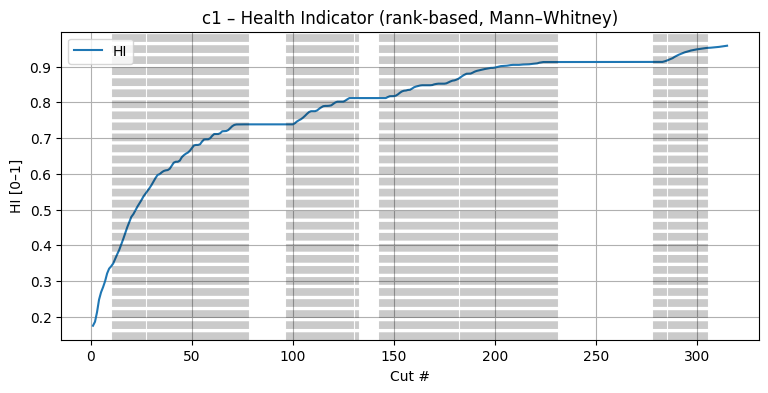

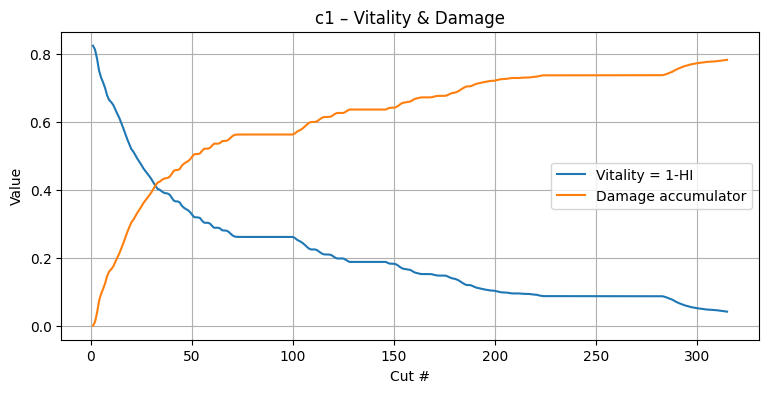

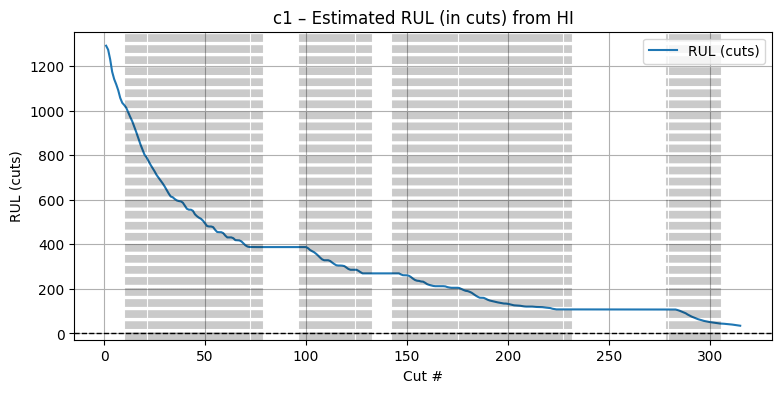

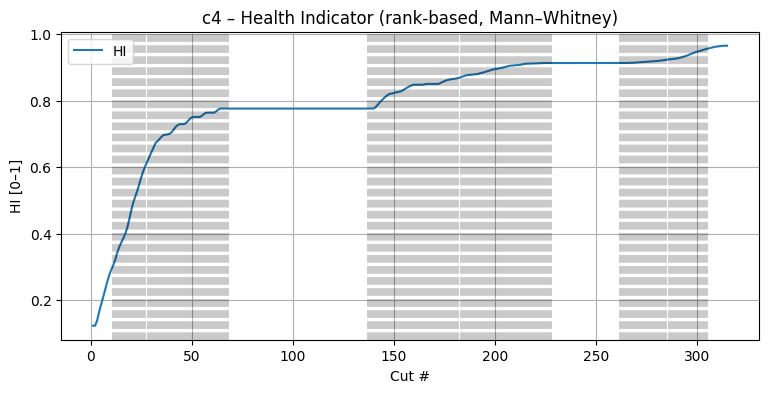

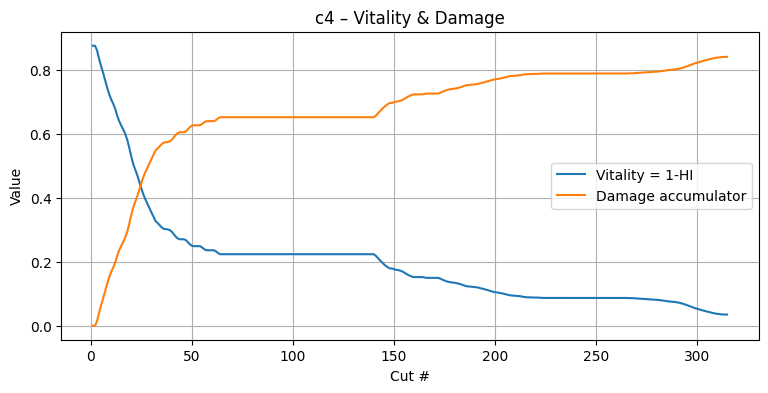

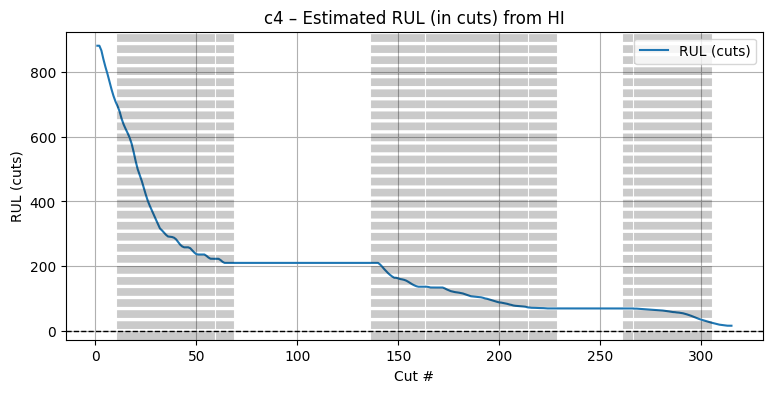

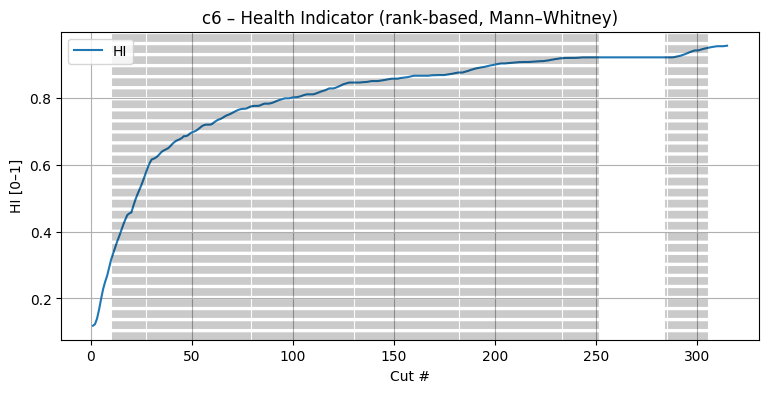

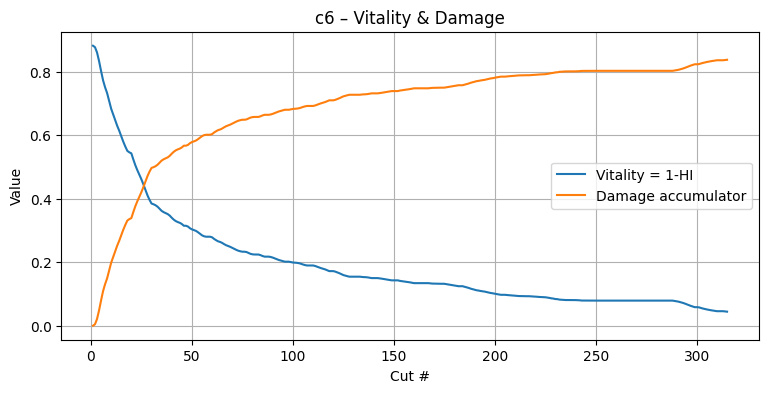

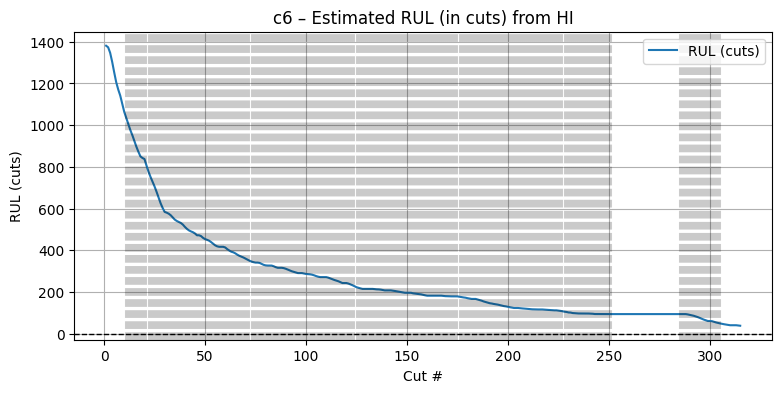

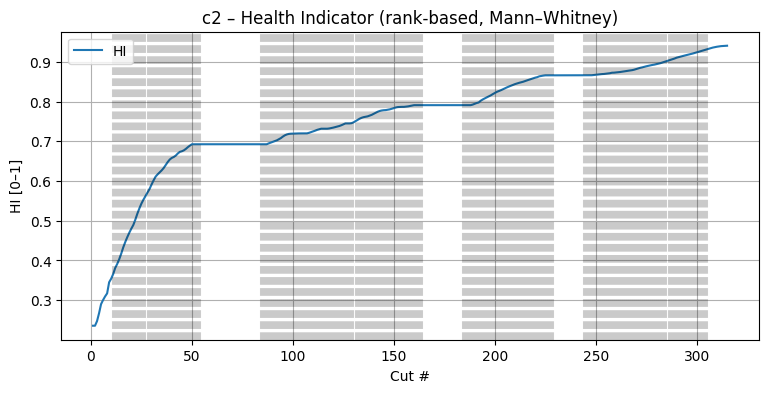

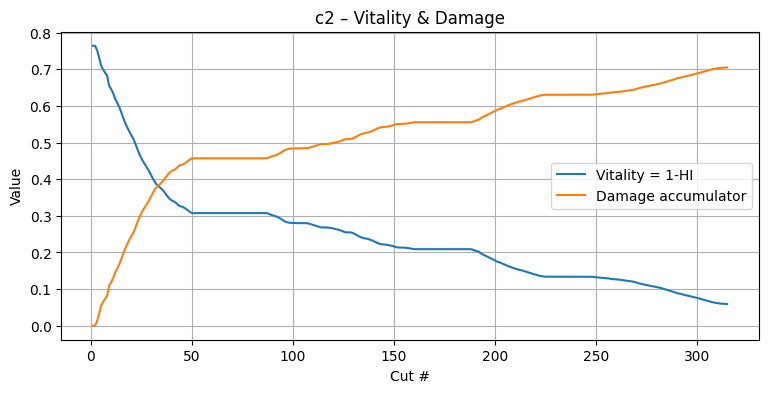

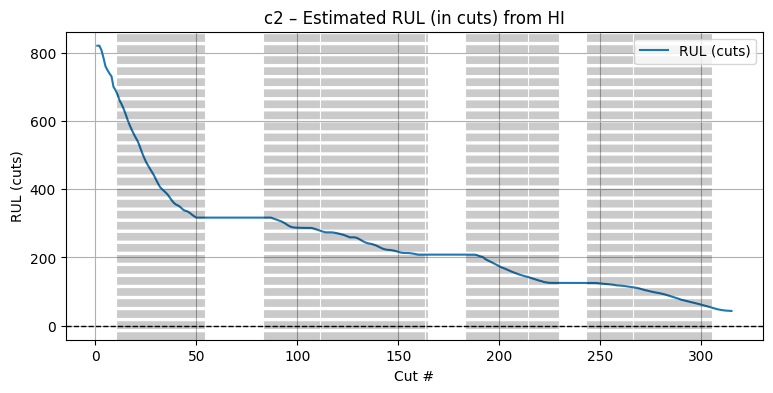

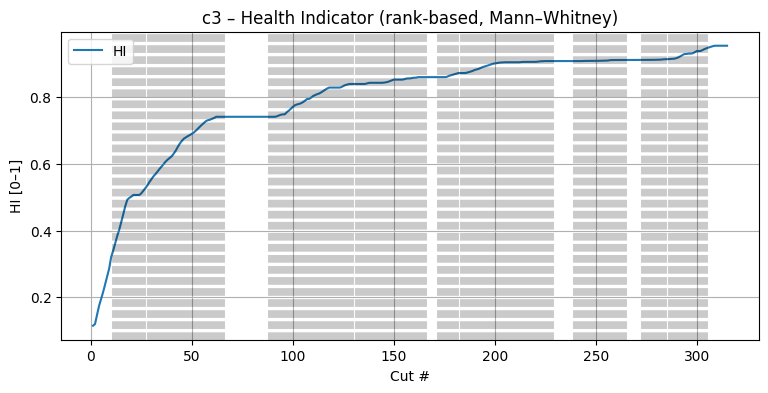

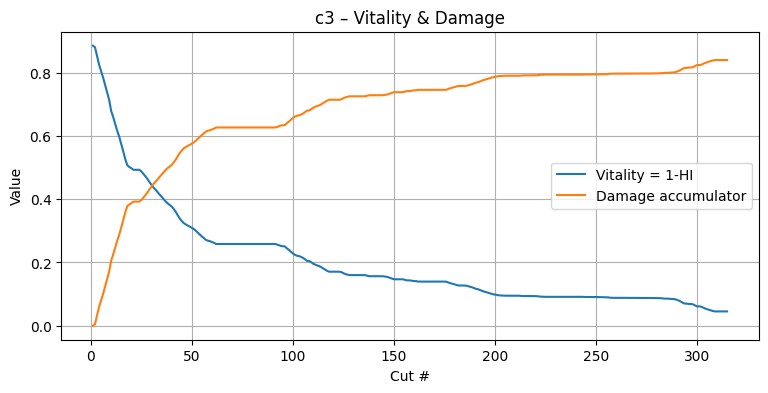

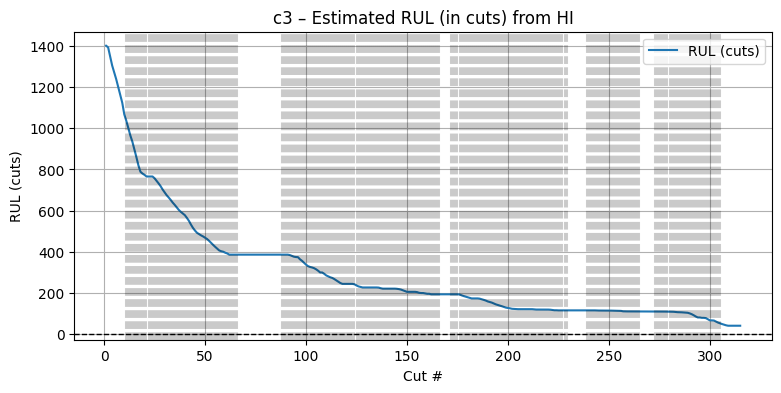

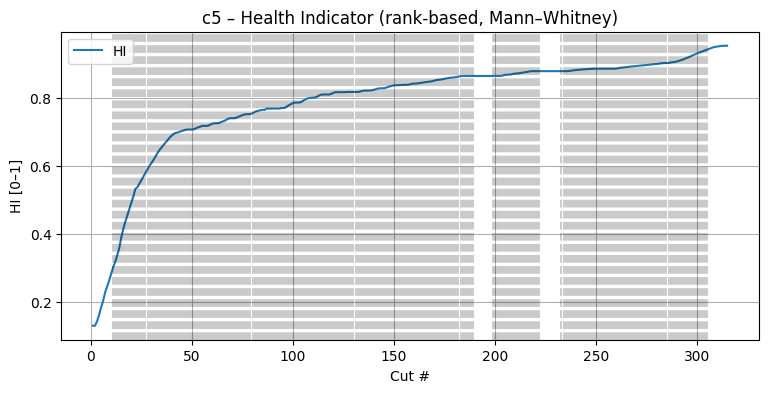

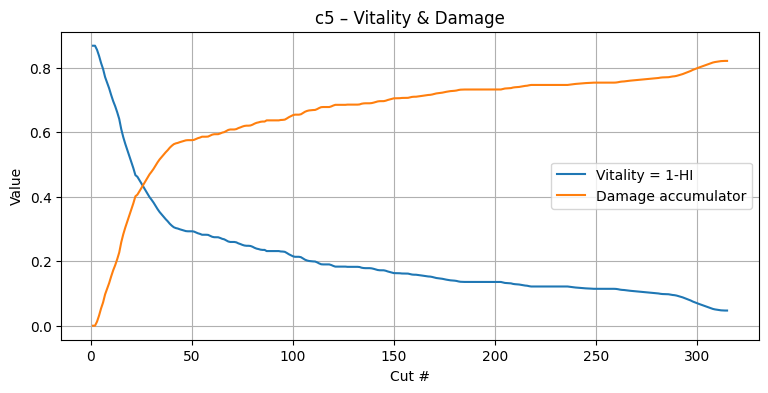

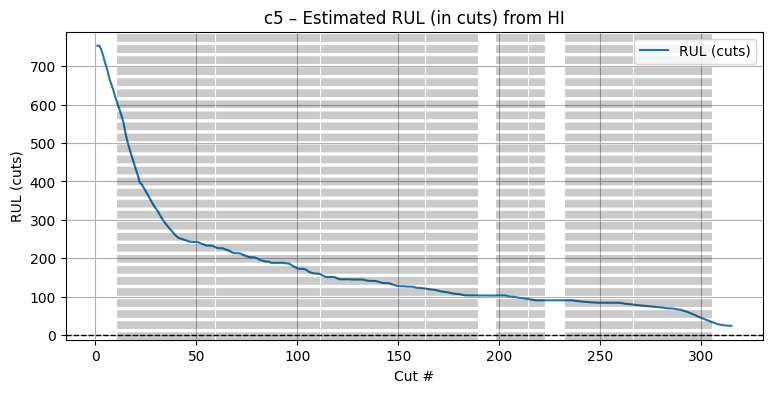

In [6]:
results = {}

for cname in TRAIN_CUTTERS + TEST_CUTTERS:
    dfF = store[cname]["features"]
    HI, vitality, damage = health_indicator_for_cutter(dfF, polarity, weights)
    cps = double_mw_change_points(HI)
    k   = slope_last_segment(HI, cps)
    RUL_cuts = rul_in_cuts_series(HI, k)

    out = pd.DataFrame({
        "cut": dfF["cut"].values,
        "HI": HI,
        "Vitality": vitality,
        "Damage": damage,
        "RUL_cuts": RUL_cuts
    })
    out["cutter"] = cname
    results[cname] = {"df": out, "cps": cps, "slope": k}

    # ---- plots ----
    x = out["cut"].values
    plt.figure(figsize=(9,4))
    plt.plot(x, out["HI"], label="HI")
    for cp in cps: plt.axvline(x[cp], color="k", alpha=0.2, ls="--")
    plt.title(f"{cname} – Health Indicator (rank-based, Mann–Whitney)")
    plt.xlabel("Cut #"); plt.ylabel("HI [0–1]"); plt.grid(True); plt.legend(); plt.show()

    plt.figure(figsize=(9,4))
    plt.plot(x, out["Vitality"], label="Vitality = 1-HI")
    plt.plot(x, out["Damage"], label="Damage accumulator")
    plt.title(f"{cname} – Vitality & Damage")
    plt.xlabel("Cut #"); plt.ylabel("Value"); plt.grid(True); plt.legend(); plt.show()

    plt.figure(figsize=(9,4))
    plt.plot(x, out["RUL_cuts"], label="RUL (cuts)")
    plt.axhline(0, color="k", ls="--", lw=1)
    for cp in cps: plt.axvline(x[cp], color="k", alpha=0.2, ls="--")
    plt.title(f"{cname} – Estimated RUL (in cuts) from HI")
    plt.xlabel("Cut #"); plt.ylabel("RUL (cuts)"); plt.grid(True); plt.legend(); plt.show()


In [7]:
def eval_against_wear(cname, results, store):
    out = results[cname]["df"].merge(
        store[cname]["wear"], left_on="cut", right_on="Cut_Number", how="inner"
    ).sort_values("cut")
    if out.empty: 
        return None
    wear = out["wear_max"].values
    hi   = out["HI"].values
    # correlation & monotonicity
    from scipy.stats import spearmanr, kendalltau
    corr_s = spearmanr(hi, wear).correlation
    tau    = kendalltau(hi, wear).correlation
    return {"spearman": float(corr_s), "kendall_tau": float(tau)}

for cname in TRAIN_CUTTERS:
    m = eval_against_wear(cname, results, store)
    print(cname, "→", m)


c1 → {'spearman': 0.995697101972714, 'kendall_tau': 0.9729924095291809}
c4 → {'spearman': 0.9905191662252948, 'kendall_tau': 0.9527844302160164}
c6 → {'spearman': 0.9985036541207929, 'kendall_tau': 0.9869910946652288}


In [8]:
channels = ["Fx","Fy","Fz","Vx","Vy","Vz","AE"]
stats    = ["mean","std","rms","max","power","centroid","crest"]
feat_names = [f"{ch}_{st}" for ch in channels for st in stats]  # 7*7 = 49

topk = 15
idx  = np.argsort(weights)[::-1][:topk]
print("Top features (by weight):")
for i in idx:
    arrow = "↑" if polarity[i] > 0 else "↓"
    print(f"{i:2d}  {feat_names[i]:>12}   w={weights[i]:.3f}   polarity={arrow}")


Top features (by weight):
32      Vy_power   w=0.027   polarity=↓
37        Vz_rms   w=0.027   polarity=↓
36        Vz_std   w=0.027   polarity=↓
39      Vz_power   w=0.027   polarity=↓
11      Fy_power   w=0.027   polarity=↓
 8        Fy_std   w=0.027   polarity=↓
 2        Fx_rms   w=0.027   polarity=↓
 5   Fx_centroid   w=0.027   polarity=↓
 4      Fx_power   w=0.027   polarity=↓
23        Vx_rms   w=0.027   polarity=↓
22        Vx_std   w=0.027   polarity=↓
17        Fz_max   w=0.027   polarity=↓
18      Fz_power   w=0.027   polarity=↓
16        Fz_rms   w=0.027   polarity=↓
25      Vx_power   w=0.027   polarity=↓


In [9]:
def calibrate_hi_threshold(results, train_cutters, last_k=5, q=0.90):
    hi_end = []
    for c in train_cutters:
        h = results[c]["df"]["HI"].to_numpy()
        hi_end.append(np.median(h[-last_k:]))
    return float(np.quantile(hi_end, q))

HI_THRESHOLD = calibrate_hi_threshold(results, TRAIN_CUTTERS, last_k=5, q=0.90)
print("Calibrated HI threshold:", HI_THRESHOLD)


Calibrated HI threshold: 0.9632593975453673


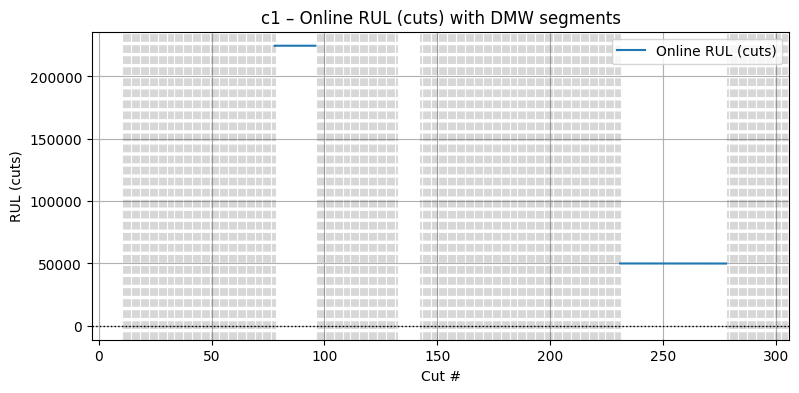

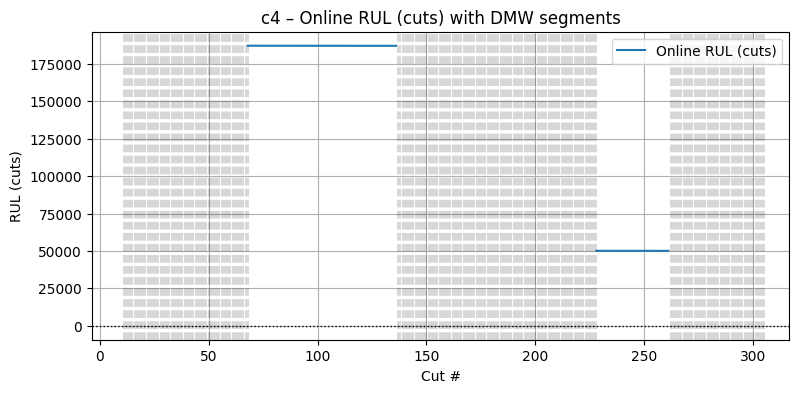

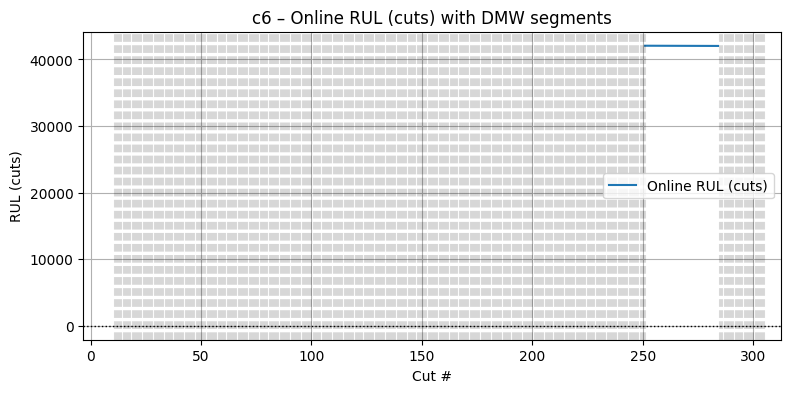

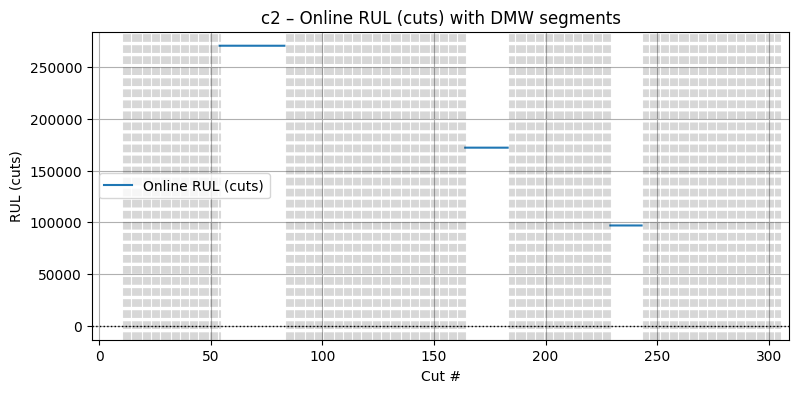

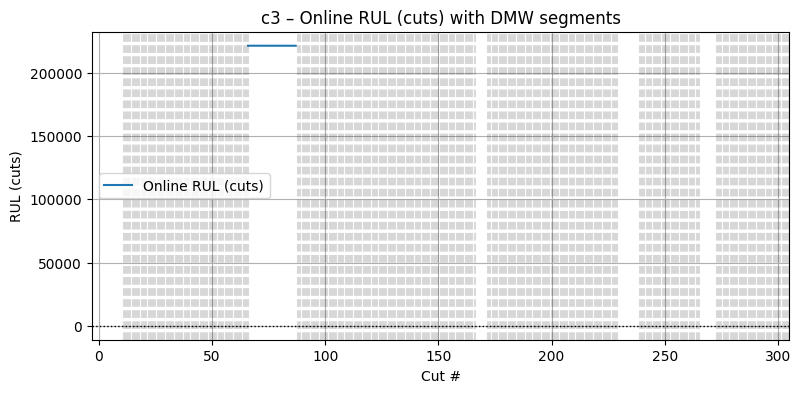

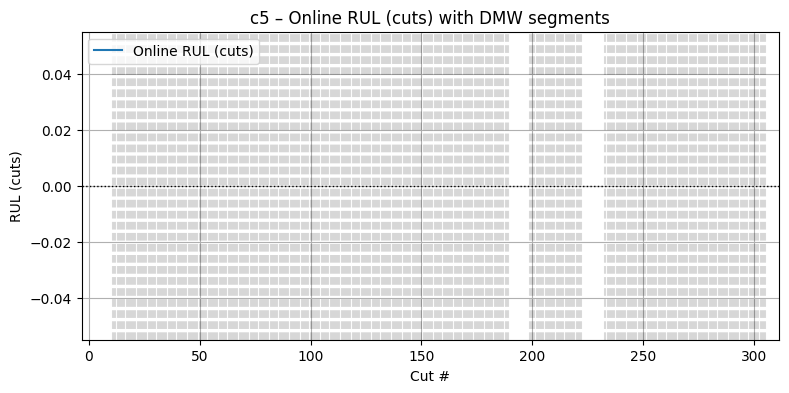

In [10]:
def piecewise_online_rul(dfF, HI, cps, hi_th=HI_THRESHOLD, min_pts=12):
    n   = len(HI); t = np.arange(n)
    seg = np.zeros(n, dtype=int)
    for k,cp in enumerate(cps):
        seg[cp:] = k+1
    # fit slope in each segment (simple OLS on HI vs cut)
    rul = np.full(n, np.nan)
    for k in range(seg.max()+1):
        mask = (seg == k)
        idx  = np.where(mask)[0]
        if idx.size < min_pts: 
            continue
        A = np.vstack([idx, np.ones_like(idx)]).T
        m,b = np.linalg.lstsq(A, HI[idx], rcond=None)[0]
        m = max(float(m), 1e-6)  # slope≥0
        tfail = (hi_th - b)/m
        rul[idx] = np.maximum(0.0, tfail - idx)
    return rul

# Build & plot for all cutters (train + test)
for cname in TRAIN_CUTTERS + TEST_CUTTERS:
    dfF = store[cname]["features"]
    HI  = results[cname]["df"]["HI"].to_numpy()
    cps = results[cname]["cps"]
    rul_cuts_pw = piecewise_online_rul(dfF, HI, cps, hi_th=HI_THRESHOLD)

    # store and plot
    results[cname]["df"]["RUL_cuts_pw"] = rul_cuts_pw
    x = results[cname]["df"]["cut"].to_numpy()
    plt.figure(figsize=(9,4))
    plt.plot(x, rul_cuts_pw, label="Online RUL (cuts)")
    for cp in cps: plt.axvline(x[cp], color="k", alpha=0.15, ls="--")
    plt.axhline(0, color="k", lw=1, ls=":")
    plt.title(f"{cname} – Online RUL (cuts) with DMW segments")
    plt.xlabel("Cut #"); plt.ylabel("RUL (cuts)"); plt.grid(True); plt.legend(); plt.show()


In [11]:
final = pd.concat([d["df"].assign(cutter=k) for k,d in results.items()], ignore_index=True)
final.to_csv("HI_vitality_damage_RUL_all_cutters.csv", index=False)
print("Saved: HI_vitality_damage_RUL_all_cutters.csv")


Saved: HI_vitality_damage_RUL_all_cutters.csv


In [12]:
# agreement already computed when learning weights; show top/bottom
agree_mat = []
for cname in TRAIN_CUTTERS:
    dfF = store[cname]["features"]
    n = len(dfF)
    Xb = stack_windows_for_cuts(dfF, list(range(min(BASELINE_CUTS, n))))
    Xl = stack_windows_for_cuts(dfF, list(range(max(0, n-LATE_CUTS_TRAIN), n)))
    eff = []
    for j in range(49):
        U = mannwhitneyu(Xb[:,j], Xl[:,j], alternative="less").statistic
        A = U/(Xb.shape[0]*Xl.shape[0])
        eff.append(2*A-1)
    agree_mat.append(np.sign(eff))
agree_mat = np.stack(agree_mat,0)
consistency = (agree_mat == np.sign(np.median(agree_mat,0))).mean(0)

ix = np.argsort(consistency)
print("Least consistent features:")
for i in ix[:8]:  print(f"{feat_names[i]:>12}  consistency={consistency[i]:.2f}")
print("Most consistent features:")
for i in ix[-8:]: print(f"{feat_names[i]:>12}  consistency={consistency[i]:.2f}")


Least consistent features:
    Vx_crest  consistency=0.67
 Fz_centroid  consistency=0.67
    Vy_crest  consistency=0.67
 Vy_centroid  consistency=0.67
 Vz_centroid  consistency=0.67
    Vz_crest  consistency=0.67
     Fx_mean  consistency=1.00
      Fx_std  consistency=1.00
Most consistent features:
      Vz_max  consistency=1.00
     AE_mean  consistency=1.00
      AE_std  consistency=1.00
      AE_rms  consistency=1.00
      AE_max  consistency=1.00
    AE_power  consistency=1.00
 AE_centroid  consistency=1.00
    AE_crest  consistency=1.00


In [13]:
def dmw_pvals(HI, win_left=DMW_WIN_LEFT, win_right=DMW_WIN_RIGHT):
    pvals = []
    for t in range(win_left, len(HI)-win_right):
        L = HI[t-win_left:t]; R = HI[t:t+win_right]
        p1 = mannwhitneyu(L, R, alternative="less").pvalue
        p2 = mannwhitneyu(R, L, alternative="greater").pvalue
        pvals.append(max(p1,p2))
    return np.array(pvals)

for cname in ["c1","c4","c6"]:
    HI = results[cname]["df"]["HI"].to_numpy()
    p  = dmw_pvals(HI)
    print(cname, "min p≈", float(np.min(p)))


c1 min p≈ 2.9681617547041613e-05
c4 min p≈ 2.9681617547041613e-05
c6 min p≈ 3.0791093228749174e-05


Decay prior floor (k): 1.9104819449881532e-19


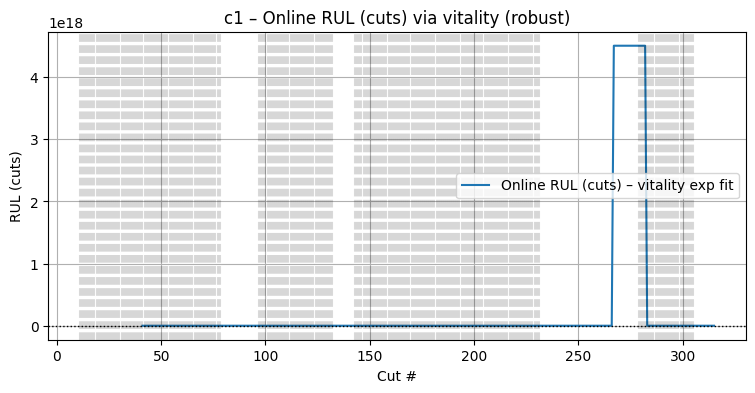

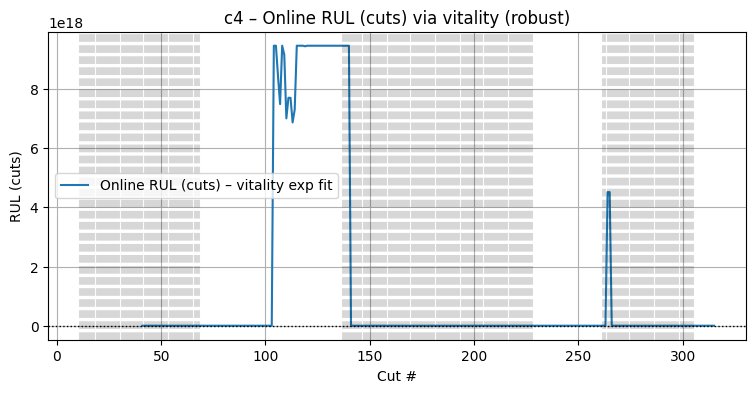

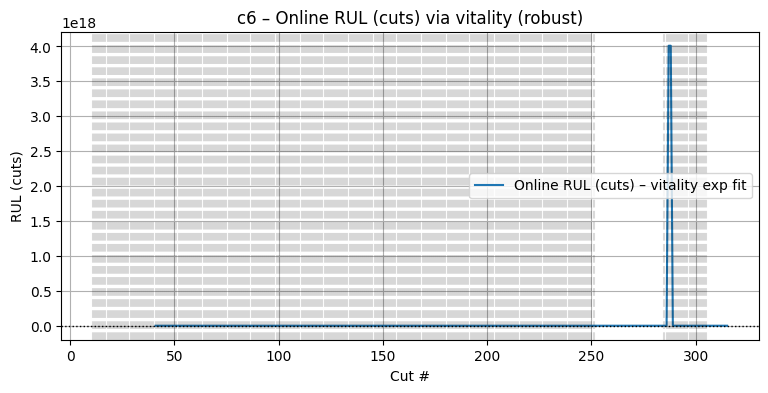

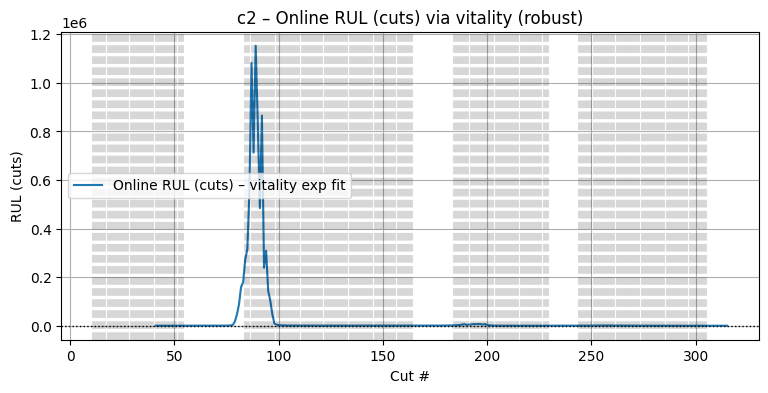

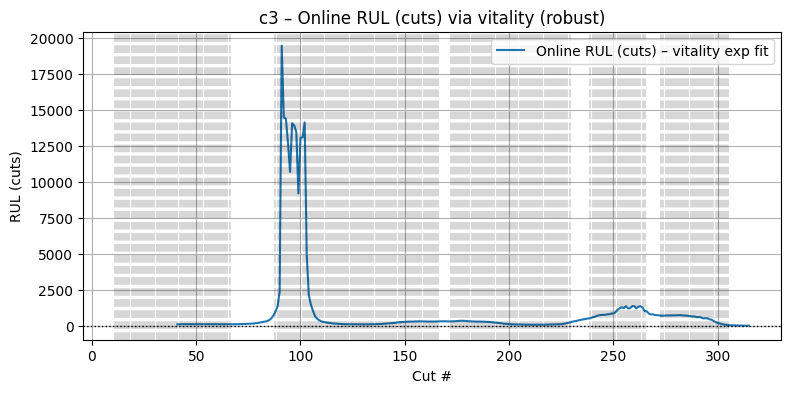

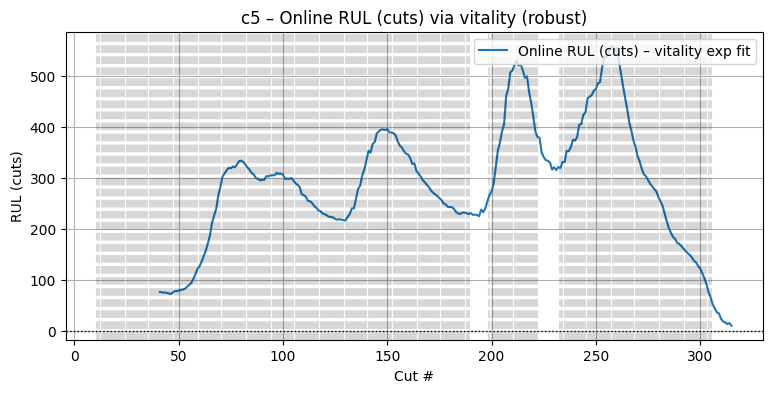

In [14]:
from sklearn.linear_model import TheilSenRegressor

# 1) learn a prior decay floor from train cutters
def collect_decay_prior(results, store, window=40):
    ks = []
    for cname in TRAIN_CUTTERS:
        d = results[cname]["df"].sort_values("cut")
        t = d["cut"].to_numpy().astype(float)
        v = np.clip(1.0 - d["HI"].to_numpy(), 1e-6, 1.0)
        if len(t) <= window: 
            continue
        for i in range(window, len(t)):
            tt = t[i-window:i+1].reshape(-1,1)
            yy = np.log(v[i-window:i+1])
            try:
                mdl = TheilSenRegressor(random_state=SEED).fit(tt, yy)
            except Exception:
                continue
            a = float(mdl.coef_[0])         # log V ≈ a t + b  (a should be negative)
            if a < 0:
                ks.append(-a)               # positive decay rate k = -a
    return np.array(ks, dtype=float)

prior_ks = collect_decay_prior(results, store, window=40)
k_floor  = float(np.percentile(prior_ks, 5)) if prior_ks.size else 1e-5
print("Decay prior floor (k):", k_floor)

# 2) online RUL via robust exponential on vitality
def online_rul_vitality(d, hi_threshold, window=40, k_min=None):
    """
    d: DataFrame with columns 'cut', 'HI' (monotone)
    RUL formula: log V = a t + b, with a<0.  For V_th=1-HI_th:
                 t_fail = (log(V_th) - b)/a,   RUL = t_fail - t
    """
    t  = d["cut"].to_numpy().astype(float)
    V  = np.clip(1.0 - d["HI"].to_numpy(), 1e-6, 1.0)
    V_th = max(1.0 - hi_threshold, 1e-6)

    rul = np.full_like(t, np.nan, dtype=float)
    for i in range(window, len(t)):
        tt = t[i-window:i+1].reshape(-1,1)
        yy = np.log(V[i-window:i+1])
        try:
            mdl = TheilSenRegressor(random_state=SEED).fit(tt, yy)
        except Exception:
            continue
        a = float(mdl.coef_[0])            # should be negative
        b = float(mdl.intercept_)
        # enforce a reasonable decay rate using prior
        if a >= 0:
            a = - (k_min if k_min is not None else 1e-6)
        elif k_min is not None:
            a = min(a, -k_min)             # a is negative; clamp magnitude below floor

        t_fail = (np.log(V_th) - b) / a    # since a<0, this is > current t if V>V_th
        rul[i] = max(0.0, t_fail - t[i])
    return rul

# 3) compute & plot for all cutters
for cname in TRAIN_CUTTERS + TEST_CUTTERS:
    df = results[cname]["df"].sort_values("cut").copy()
    df["RUL_cuts_online"] = online_rul_vitality(df, HI_THRESHOLD, window=40, k_min=k_floor)
    results[cname]["df"] = df

    x = df["cut"].to_numpy()
    y = df["RUL_cuts_online"].to_numpy()
    plt.figure(figsize=(9,4))
    plt.plot(x, y, label="Online RUL (cuts) – vitality exp fit")
    for cp in results[cname]["cps"]:
        plt.axvline(x[cp], color="k", alpha=0.15, ls="--")
    plt.axhline(0, color="k", lw=1, ls=":")
    plt.title(f"{cname} – Online RUL (cuts) via vitality (robust)")
    plt.xlabel("Cut #"); plt.ylabel("RUL (cuts)"); plt.grid(True); plt.legend(); plt.show()


[Floors] k_floor=0.002545  delta_floor=0.001  delta_cap=0.02


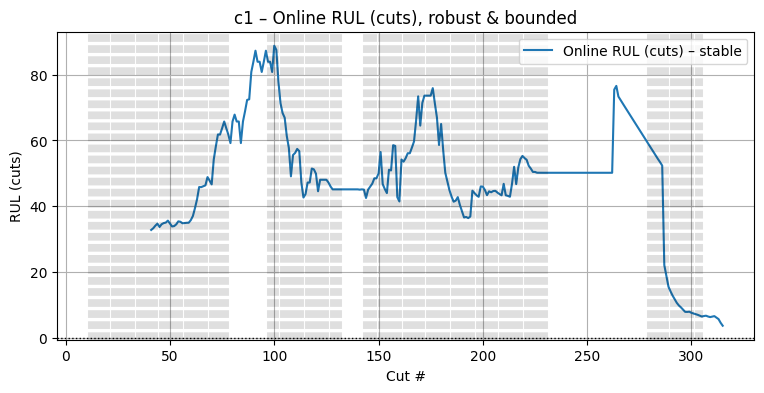

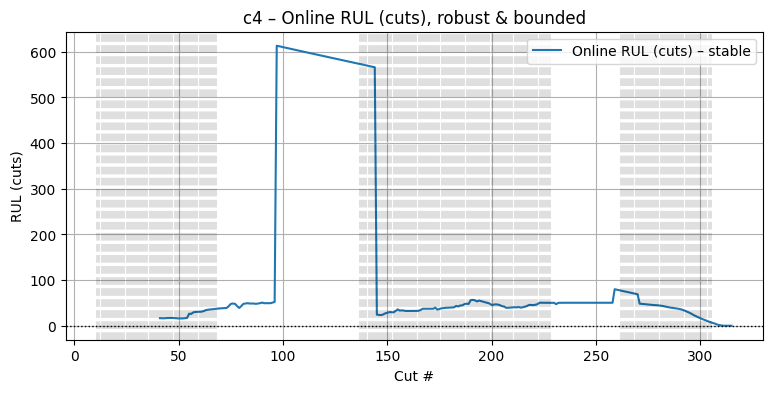

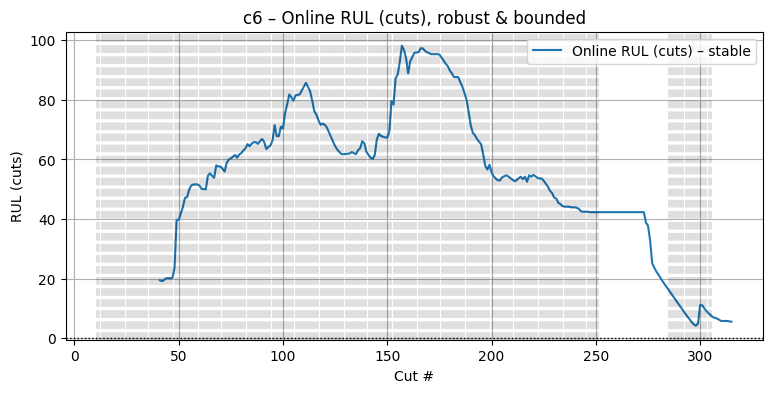

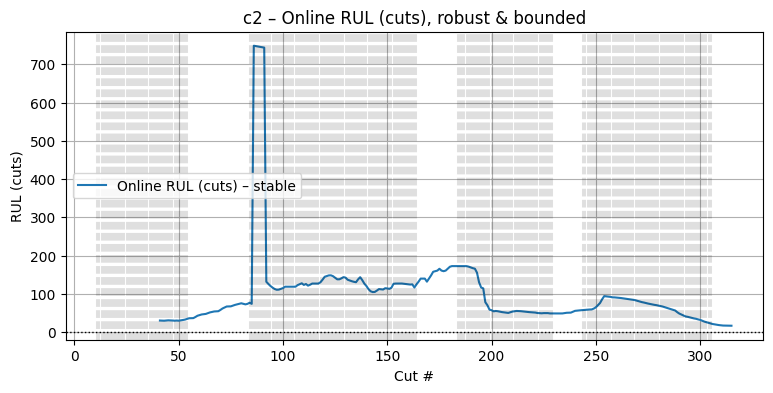

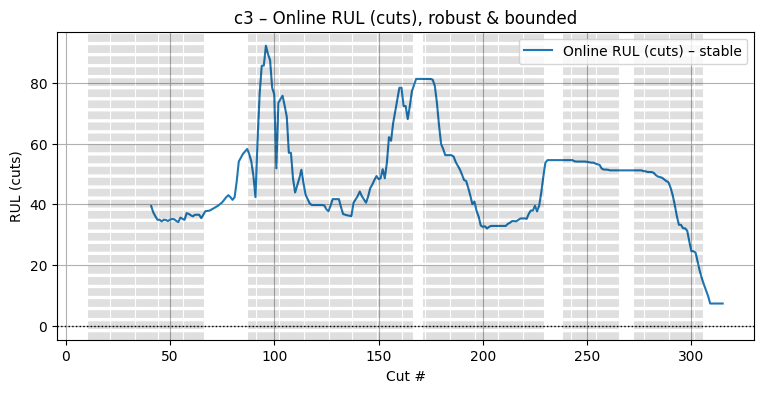

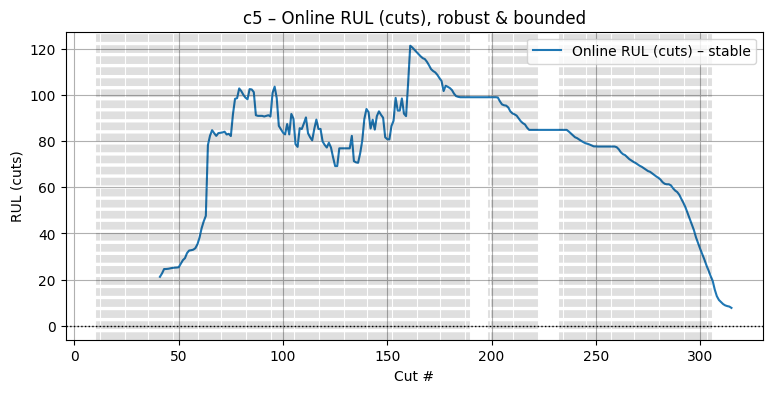

In [15]:
from sklearn.linear_model import TheilSenRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- helpers: safe percentiles ----------
def _safe_pct(x, q, default):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    return (np.quantile(x, q) if x.size else default)

# ---------- learn sensible floors from TRAIN cutters ----------
def learn_rate_floors(results, train_cutters, window=40):
    ks, deltas = [], []
    for cname in train_cutters:
        d  = results[cname]["df"].sort_values("cut")
        t  = d["cut"].to_numpy().astype(float)
        HI = d["HI"].to_numpy().astype(float)
        V  = np.clip(1.0 - HI, 1e-6, 1.0)
        # vitality decay rates (k = -d/dt log V)
        if len(t) > window:
            for i in range(window, len(t)):
                tt = t[i-window:i+1].reshape(-1,1)
                yy = np.log(V[i-window:i+1])
                try:
                    m = TheilSenRegressor(random_state=42).fit(tt, yy)
                    a = float(m.coef_[0])
                    if a < 0: ks.append(-a)
                except Exception:
                    pass
        # positive HI increments
        dHI = np.diff(HI)
        pos = dHI[dHI > 0]
        if pos.size:
            roll = pd.Series(pos).rolling(15, min_periods=5).median().dropna().to_numpy()
            deltas.extend(roll.tolist())

    # floors (don’t let them be tiny)
    k_floor     = max(_safe_pct(ks,     0.25, 0.0), 5e-4)   # per-cut vitality decay
    delta_floor = max(_safe_pct(deltas, 0.10, 0.0), 1e-3)   # per-cut HI increase
    delta_cap   = max(_safe_pct(deltas, 0.95, 0.03), 0.02)  # avoid unrealistically steep ΔHI

    print(f"[Floors] k_floor={k_floor:.4g}  delta_floor={delta_floor:.4g}  delta_cap={delta_cap:.4g}")
    return k_floor, delta_floor, delta_cap

# call this ONCE (after you built 'results' on train cutters)
k_floor, delta_floor, delta_cap = learn_rate_floors(results, TRAIN_CUTTERS, window=40)

# ---------- method A: vitality-exponential (robust) ----------
def rul_vitality_exp(df, hi_threshold, window=40, k_min=5e-4):
    t  = df["cut"].to_numpy().astype(float)
    HI = df["HI"].to_numpy().astype(float)
    V  = np.clip(1.0 - HI, 1e-6, 1.0)
    V_th = max(1.0 - hi_threshold, 1e-6)

    rul = np.full_like(t, np.nan, float)
    for i in range(window, len(t)):
        tt = t[i-window:i+1].reshape(-1,1)
        yy = np.log(V[i-window:i+1])
        try:
            mdl = TheilSenRegressor(random_state=42).fit(tt, yy)
            a = float(mdl.coef_[0])        # should be negative
            b = float(mdl.intercept_)
        except Exception:
            continue
        # clamp slope (a < 0) using a sensible floor
        if not np.isfinite(a) or a >= 0:
            a = -k_min
        else:
            a = min(a, -k_min)             # a is negative; ensure |a| >= k_min

        t_fail = (np.log(V_th) - b) / a    # with a < 0 → finite
        rul[i] = max(0.0, t_fail - t[i])
    return rul

# ---------- method B: median positive ΔHI (per-cut linear) ----------
def rul_delta_hi(df, hi_threshold, window=40, delta_min=1e-3, delta_max=0.03):
    HI = df["HI"].to_numpy().astype(float)
    t  = df["cut"].to_numpy().astype(float)
    rul = np.full_like(t, np.nan, float)
    for i in range(window, len(HI)):
        dHI = np.diff(HI[i-window:i+1])
        pos = dHI[dHI > 0]
        if pos.size < 5:
            continue
        delta = float(np.median(pos))
        delta = float(np.clip(delta, delta_min, delta_max))
        rem   = max(0.0, hi_threshold - HI[i])
        rul[i] = rem / delta
    return rul

# ---------- combine: conservative RUL (min of both) ----------
def compute_stable_rul_series(df, hi_threshold, k_min, delta_min, delta_max, window=40):
    r_exp = rul_vitality_exp(df, hi_threshold, window=window, k_min=k_min)
    r_dhi = rul_delta_hi(df, hi_threshold, window=window, delta_min=delta_min, delta_max=delta_max)
    R = np.fmin(np.nan_to_num(r_exp, nan=np.inf), np.nan_to_num(r_dhi, nan=np.inf))
    R[~np.isfinite(R)] = np.nan
    return R

# ---------- apply & plot ----------
for cname in TRAIN_CUTTERS + TEST_CUTTERS:
    df = results[cname]["df"].sort_values("cut").copy()
    df["RUL_cuts_stable"] = compute_stable_rul_series(
        df, HI_THRESHOLD, k_min=k_floor, delta_min=delta_floor, delta_max=delta_cap, window=40
    )
    results[cname]["df"] = df

    x = df["cut"].to_numpy()
    y = df["RUL_cuts_stable"].to_numpy()
    plt.figure(figsize=(9,4))
    plt.plot(x, y, label="Online RUL (cuts) – stable")
    for cp in results[cname]["cps"]:
        plt.axvline(x[cp], color="k", alpha=0.12, ls="--")
    plt.axhline(0, color="k", lw=1, ls=":")
    plt.title(f"{cname} – Online RUL (cuts), robust & bounded")
    plt.xlabel("Cut #"); plt.ylabel("RUL (cuts)"); plt.grid(True); plt.legend(); plt.show()
